In [1]:
import logging
import warnings

warnings.filterwarnings("ignore")
logging.getLogger("pytensor").setLevel(logging.ERROR)

# Structural Shocks in the Atmosphere

A reduced-form VAR tells you that variables move together, but not *why*. Structural
identification imposes causal assumptions to decompose forecast errors into
interpretable shocks. In macroeconomics, the ordering of variables is endlessly
debated. In atmospheric science, the physics gives us a defensible answer.

This tutorial fits a Bayesian VAR to daily weather observations from the
[Cabauw Mast](https://www.knmi.nl/kennis-en-datacentrum/uitleg/meetmast-cabauw),
a 213-metre atmospheric research tower in the Netherlands operated by KNMI. We identify
structural shocks using a Cholesky decomposition ordered by physical causation, then
trace their effects through impulse response functions, forecast error variance
decomposition, and historical decomposition.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from impulso import VAR, VARData, select_lag_order
from impulso.identification import Cholesky
from impulso.samplers import NUTSSampler

## Load and rescale

The data file contains daily observations from KNMI station 348 (Cabauw), covering
January 2020 to February 2026. KNMI reports temperature, pressure, and wind speed in
tenths of their natural units, so we rescale on ingestion.

| Variable | Code | Raw unit | Rescaled |
|----------|------|----------|----------|
| Sea-level pressure | PG | 0.1 hPa | hPa |
| Wind speed | FG | 0.1 m/s | m/s |
| Temperature | TG | 0.1 C | C |
| Relative humidity | UG | % | % |

In [ ]:
df = pd.read_csv(
    "data/cabauw_mast.txt",
    comment="#",
    skipinitialspace=True,
    usecols=[1, 2, 3, 4, 5],
    names=["date", "wind", "temperature", "pressure", "humidity"],
    header=0,
    dtype={"date": str},
)
df["date"] = pd.to_datetime(df["date"].str.strip(), format="%Y%m%d")
df = df.set_index("date").sort_index()

df["temperature"] = df["temperature"] / 10
df["pressure"] = df["pressure"] / 10
df["wind"] = df["wind"] / 10

df = df[["pressure", "wind", "temperature", "humidity"]].dropna()
df.describe().round(1)

pressure    wind  temperature  humidity
count    2239.0  2239.0       2239.0    2239.0
mean     1015.2     4.2         11.2      81.6
std        10.3     2.0          6.0      10.4
min       974.5     0.9         -5.5      40.0
25%      1009.0     2.8          6.7      76.0
50%      1015.9     3.8         11.0      83.0
75%      1022.2     5.2         16.2      89.0
max      1046.8    13.8         28.4      99.0

## Remove the seasonal cycle

Temperature has a strong annual cycle that violates VAR stationarity assumptions. Pressure and humidity also have weaker seasonal patterns. We remove these by fitting a harmonic regression - two pairs of sine and cosine terms at annual and semi-annual frequencies - to each variable and subtracting the fitted values. The residuals are the *anomalies* we model.

In [ ]:
doy = df.index.day_of_year.values
omega = 2 * np.pi / 365.25

X_season = np.column_stack([
    np.ones(len(doy)),
    np.sin(omega * doy),
    np.cos(omega * doy),
    np.sin(2 * omega * doy),
    np.cos(2 * omega * doy),
])

anomalies = pd.DataFrame(index=df.index)
climatology = pd.DataFrame(index=df.index)

for col in df.columns:
    y = df[col].values
    beta, *_ = np.linalg.lstsq(X_season, y, rcond=None)
    fitted = X_season @ beta
    climatology[col] = fitted
    anomalies[col] = y - fitted

The left column below shows each raw series with its fitted seasonal cycle overlaid in red; the
right column shows the resulting anomalies. Notice how the annual swing in temperature (roughly
±10°C) dominates the raw series but is absent from the anomalies, leaving only the day-to-day
fluctuations driven by passing weather systems.

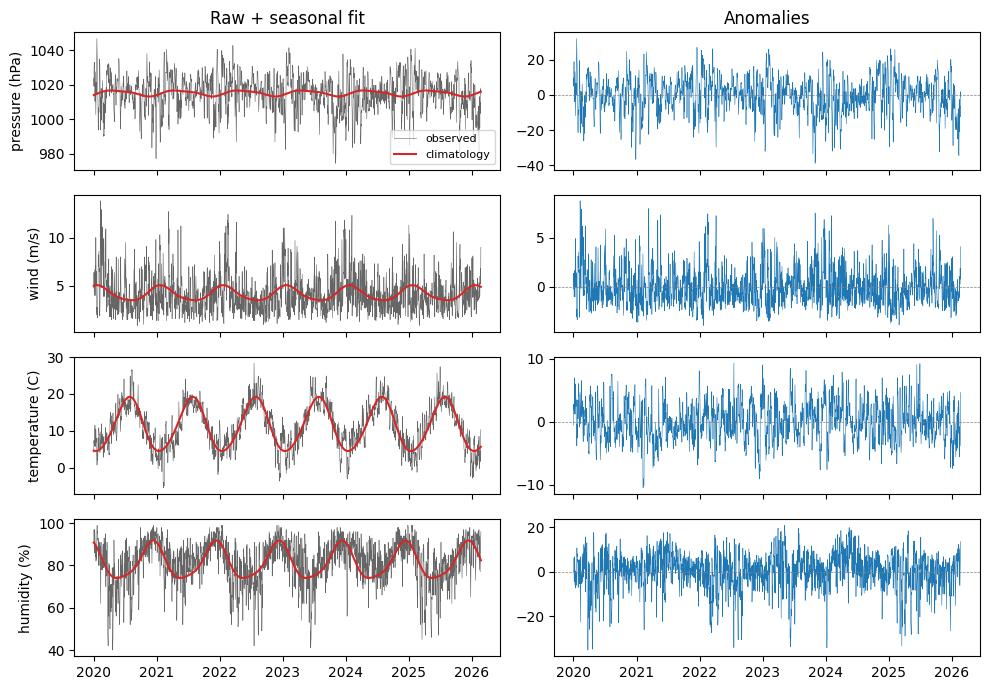

In [ ]:
fig, axes = plt.subplots(4, 2, figsize=(10, 7), sharex="col")
units = {"pressure": "hPa", "wind": "m/s", "temperature": "C", "humidity": "%"}

for i, col in enumerate(df.columns):
    axes[i, 0].plot(df.index, df[col], linewidth=0.4, color="0.4", label="observed")
    axes[i, 0].plot(df.index, climatology[col], color="C3", linewidth=1.5, label="climatology")
    axes[i, 0].set_ylabel(f"{col} ({units[col]})")
    if i == 0:
        axes[i, 0].legend(fontsize=8)
        axes[i, 0].set_title("Raw + seasonal fit")

    axes[i, 1].plot(df.index, anomalies[col], linewidth=0.4, color="C0")
    axes[i, 1].axhline(0, color="0.5", linewidth=0.5, linestyle="--")
    if i == 0:
        axes[i, 1].set_title("Anomalies")

fig.tight_layout()

## Build the VAR dataset

We pass the anomalies to `VARData.from_df()`. The column order --
pressure, wind, temperature, humidity -- will carry through to the Cholesky
identification later.

In [6]:
data = VARData.from_df(anomalies, endog=["pressure", "wind", "temperature", "humidity"])
data

VARData(endog=array([[ 9.64830648, -0.20866846, -0.51723724,  6.14473059],
       [ 5.01230309,  1.38446876,  2.8035835 ,  0.24097968],
       [15.97581465, -0.12204568,  1.92249927,  0.34132409],
       ...,
       [-0.04194567,  0.77564679,  0.3528681 ,  6.17397374],
       [ 1.8261302 ,  1.38544071,  3.79884319,  8.3680157 ],
       [-0.80520377,  4.09547869,  4.64364881, 13.56147305]],
      shape=(2239, 4)), endog_names=['pressure', 'wind', 'temperature', 'humidity'], exog=None, exog_names=None, index=DatetimeIndex(['2020-01-02', '2020-01-03', '2020-01-04', '2020-01-05',
               '2020-01-06', '2020-01-07', '2020-01-08', '2020-01-09',
               '2020-01-10', '2020-01-11',
               ...
               '2026-02-13', '2026-02-14', '2026-02-15', '2026-02-16',
               '2026-02-17', '2026-02-18', '2026-02-19', '2026-02-20',
               '2026-02-21', '2026-02-22'],
              dtype='datetime64[us]', name='date', length=2239, freq=None))

## Select lag order

We test lags 1 through 14 using information criteria. Synoptic weather systems take
roughly 5--7 days to cross the Netherlands, so we expect the optimal lag to fall in
that range.

In [ ]:
ic = select_lag_order(data, max_lags=14)
print(f"AIC selects {ic.aic} lag(s), BIC selects {ic.bic} lag(s), HQ selects {ic.hq} lag(s)")
ic.summary()

AIC selects 3 lag(s), BIC selects 2 lag(s), HQ selects 3 lag(s)


aic       bic        hq
lag                              
1    9.093343  9.144400  9.111983
2    8.904730  8.996668  8.938297
3    8.880080  9.012928  8.928584
4    8.885383  9.059170  8.948836
5    8.889046  9.103805  8.967460
6    8.894238  9.149997  8.987624
7    8.900443  9.197233  9.008814
8    8.906108  9.243960  9.029475
9    8.915200  9.294143  9.053575
10   8.921660  9.341725  9.075054
11   8.931019  9.392238  9.099445
12   8.942743  9.445144  9.126212
13   8.947023  9.490638  9.145548
14   8.953962  9.538822  9.167554

## Fit the Bayesian VAR

AIC and Hannan–Quinn both prefer 3 lags, while BIC prefers 2. We proceed with the
more parsimonious BIC choice - two lags captures the primary day-to-day persistence
while keeping the parameter space manageable (4 variables × 2 lags × 4 equations =
32 autoregressive coefficients plus intercepts and the covariance matrix).

We use a Minnesota prior, which shrinks cross-variable coefficients toward zero and
higher-lag coefficients toward zero. This is a natural regularisation choice as it
encodes the belief that each variable's own recent past is its best predictor, while
allowing the data to reveal cross-variable dynamics where the evidence is strong.
Sampling uses the NUTS algorithm across 4 chains.

In [8]:
sampler = NUTSSampler(draws=2500, tune=1000, chains=4, cores=1, random_seed=123)
fitted = VAR(lags=ic.bic, prior="minnesota").fit(data, sampler=sampler)
fitted

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [intercept, B, sigma_sd, tril_offdiag]


Output()

Sampling 4 chains for 1_000 tune and 2_500 draw iterations (4_000 + 10_000 draws total) took 75 seconds.


FittedVAR(n_lags=2, n_vars=4, n_draws=2500, n_chains=4)

## Cholesky identification

A reduced-form VAR captures correlations between forecast errors, but it cannot
distinguish cause from effect within a single time step. The Cholesky decomposition
resolves this by imposing a recursive causal ordering: variables higher in the list
can affect variables below them contemporaneously, but not vice versa. The ordering
encodes which variables can affect which others within a single day:

1. **Pressure** is most exogenous. Sea-level pressure at Cabauw is governed by
   synoptic-scale circulation far from the station; nothing at the local level
   feeds back into it within a day.
2. **Wind** responds mechanically to the pressure gradient within the same day but
   does not contemporaneously cause pressure changes.
3. **Temperature** is affected by the synoptic regime (pressure) and by advection
   and turbulent mixing (wind), but does not drive either within a day.
4. **Humidity** is most endogenous. Relative humidity depends on temperature
   (Clausius–Clapeyron), moisture advection (wind), and frontal moisture (pressure).

Unlike in macroeconomics, where the ordering of GDP, inflation, and interest rates is
a matter of ongoing debate, the atmospheric physics provides a principled and
defensible identification.

In [ ]:
identified = fitted.set_identification_strategy(Cholesky(ordering=["pressure", "wind", "temperature", "humidity"]))
identified

IdentifiedVAR(n_lags=2, n_vars=4, n_draws=2500, n_chains=4)

## Impulse response functions

An IRF traces how a one-standard-deviation structural shock propagates through the
system over subsequent time steps. Each panel in the grid below shows the response
of one variable (row) to a shock in another (column), out to 14 days — enough to
capture the full lifecycle of a typical synoptic weather event. The shaded band is
the 94% posterior credible interval.

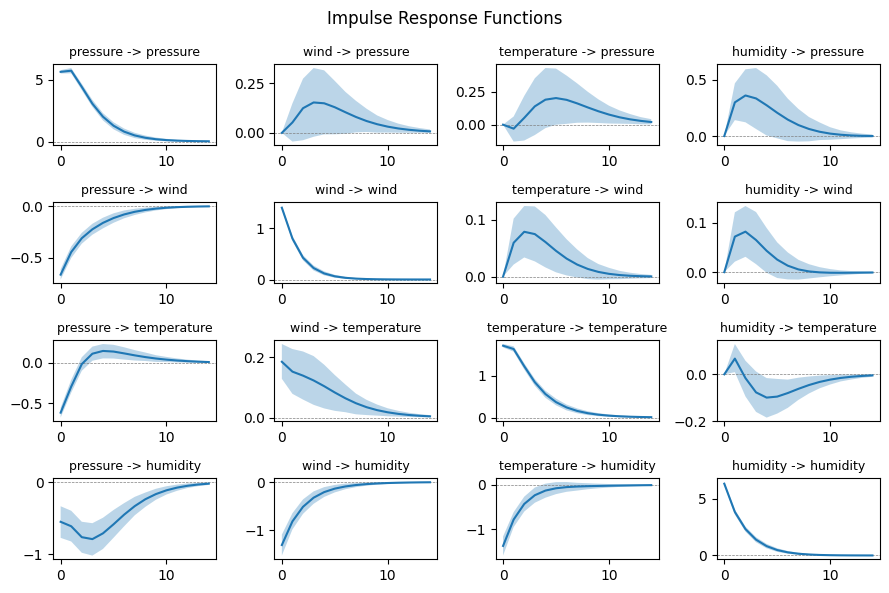

In [10]:
irf = identified.impulse_response(horizon=14)
fig = irf.plot()

Each panel in this grid shows how one weather variable at the Cabauw research tower responds over the following 14 days to an unexpected one-day disturbance in another, after seasonal patterns have been removed. The first column — the effects of a pressure shock — tells the clearest story. An anomalous rise in pressure of about 6 hPa (typical of an unexpected high-pressure system) causes wind speeds to drop by around 0.6 m/s as pressure gradients weaken, temperatures to initially fall by roughly 0.7°C as clear skies allow heat to radiate away overnight, and relative humidity to drop by about 1 percentage point as subsiding air dries out the atmosphere. These effects unfold over 2–5 days and then gradually fade, mirroring the timescale on which weather systems pass through the Netherlands.

The model also recovers a fundamental thermodynamic relationship directly from the data: an unexpected rise in temperature causes a sharp and persistent drop in relative humidity (bottom of column 3). This reflects the Clausius–Clapeyron effect — warmer air can hold more moisture, so if the amount of water vapour stays roughly constant but the air warms, relative humidity falls. The response is large (around 1.5 percentage points per °C) and persists for over 10 days, making it the single cleanest signal in the entire analysis.

Taken together, the impulse responses paint a physically coherent picture: large-scale pressure is a dominant driver of local conditions, wind acts as a mediator between the large-scale flow and surface weather, temperature responds to both but carries its own strong persistence through surface heat storage, and humidity sits at the end of the chain — reacting to everything else but driving relatively little itself. The fact that a purely statistical model, identified only by a plausible ordering of the variables, recovers these well-understood atmospheric mechanisms without any built-in physics is a compelling demonstration of what structural VAR models can do.

## Forecast error variance decomposition

The FEVD answers a different question: if I try to forecast each variable and get it
wrong, where did the error come from? Each panel below decomposes forecast uncertainty
for one variable into contributions from shocks to all four variables, over a 14-day
horizon.

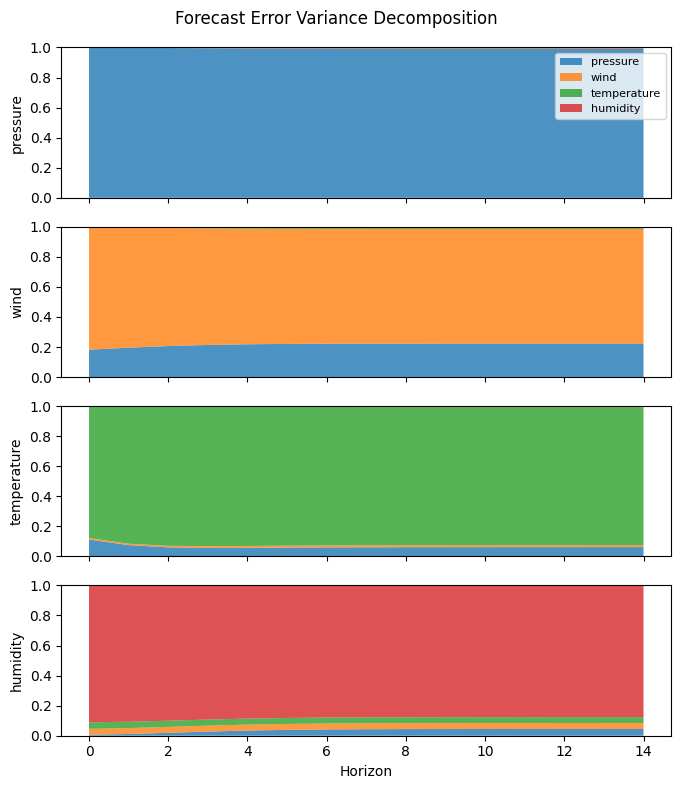

In [11]:
fevd = identified.fevd(horizon=14)
fig = fevd.plot()

The dominant pattern is that each variable is primarily driven by its own shocks — the diagonal dominates everywhere. But the asymmetries are what matter. Pressure is almost 100% self-driven at all horizons: nothing in the local system feeds back into it, confirming its role as the most exogenous variable. Wind is mostly self-driven but with a steady ~20% contribution from pressure, reflecting the influence of large-scale pressure gradients on local wind speeds. Temperature is overwhelmingly self-driven (~90%+), consistent with the strong persistence from surface heat storage seen in the IRFs.

Humidity is the most interesting panel because it's the only variable where other shocks make a visible contribution — pressure accounts for a growing ~10% share, with thin slivers from wind and temperature. This confirms humidity as the most endogenous variable in the system, absorbing influences from the rest through subsidence drying (pressure) and the Clausius–Clapeyron effect (temperature). The overall picture validates the Cholesky ordering: the causal flow runs predominantly from pressure through to humidity, not the other way around.

## Historical decomposition

The IRFs and FEVD describe the system's *average* dynamics. The historical
decomposition goes further: it attributes the *actual* observed value of each variable
at each point in time to the cumulative effect of each structural shock. This lets you
answer narrative questions — for instance, which shocks drove a particular cold snap
or an unusually calm week?

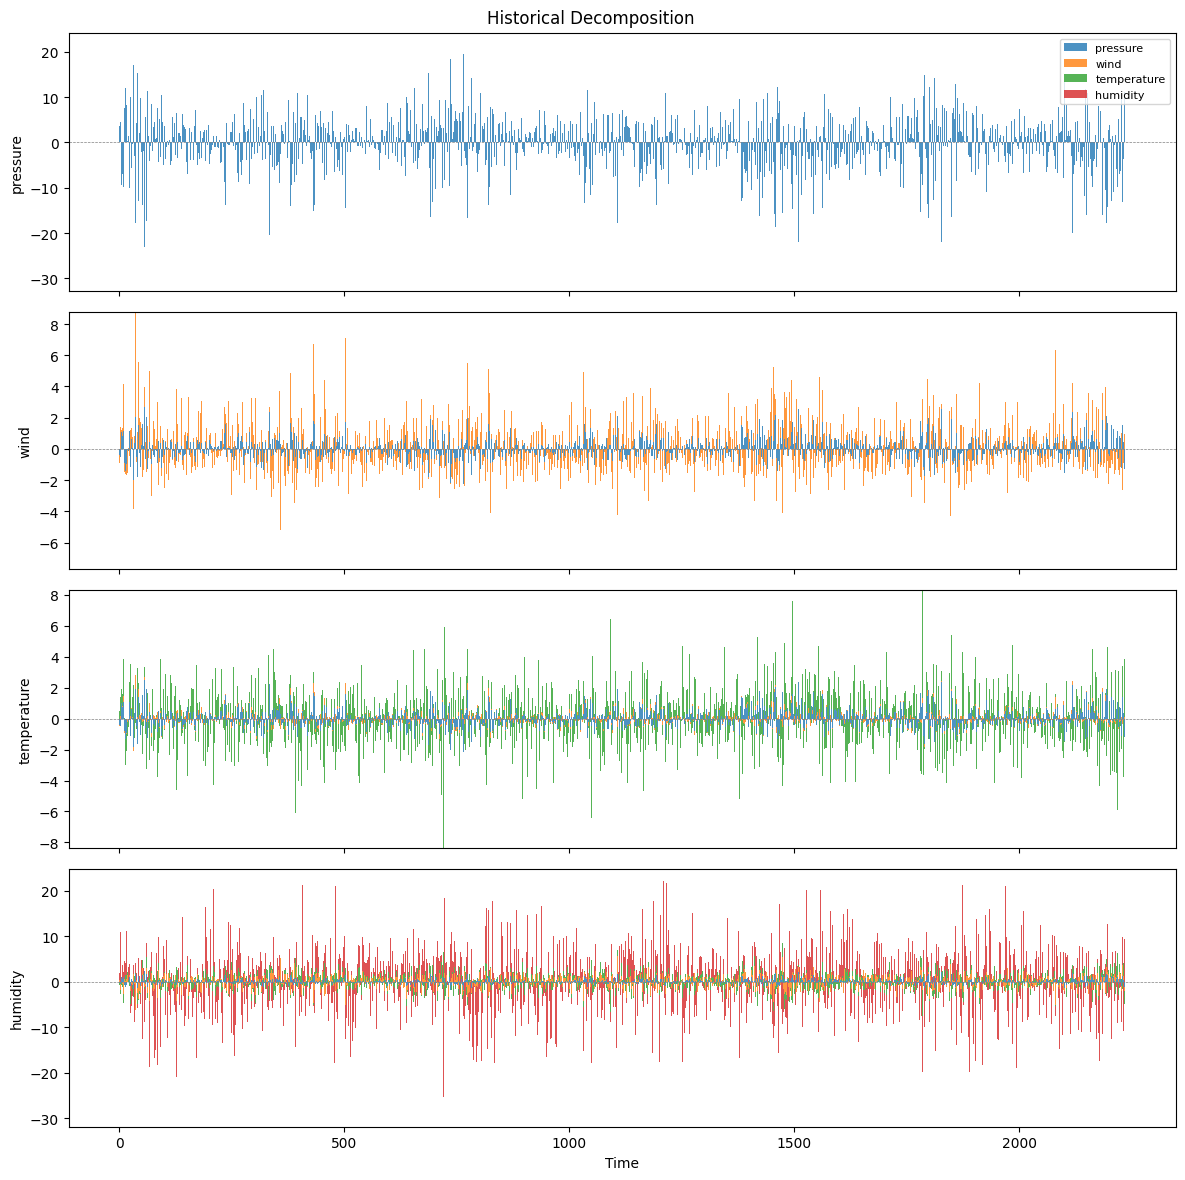

In [12]:
hd = identified.historical_decomposition()
fig = hd.plot()
plt.savefig("historical_decomposition.png", dpi=300, bbox_inches="tight")

Each panel decomposes one variable's daily anomaly into the contributions of the four structural shocks. Pressure (top) is almost entirely its own colour — its anomalies are driven by large-scale synoptic forcing with negligible feedback from local wind, temperature, or humidity. Wind (second) is also dominated by its own shocks, but a steady blue undercurrent from pressure is visible, consistent with the mechanical link between pressure gradients and wind speed. Temperature (third) shows a similar pattern: mostly self-driven through surface heat storage, with occasional pressure contributions during strong synoptic episodes. Humidity (bottom) is the most mixed panel — its own shocks dominate the high-frequency variation, but contributions from pressure and temperature are clearly visible, reflecting how frontal passages and the Clausius–Clapeyron effect modulate relative humidity on specific days. The spikiest events in each panel correspond to the passage of intense weather systems, and reading across panels for the same time period reveals how a single synoptic event propagates through the causal chain.

## Summary

This tutorial demonstrated the full structural VAR workflow on real atmospheric data:

1. **Load and clean** daily observations from KNMI's Cabauw Mast
2. **Remove seasonality** with harmonic regression to obtain stationary anomalies
3. **Select lag order** using information criteria (BIC selected 2 lags)
4. **Fit** a Bayesian VAR with `VAR(lags=..., prior="minnesota").fit(data, sampler)`
5. **Identify** structural shocks with `Cholesky(ordering=[...])`
6. **Analyse** causal dynamics with `.impulse_response()`, `.fevd()`, and
   `.historical_decomposition()`

The atmospheric setting is particularly well-suited to structural VAR analysis because
the physics provides an unambiguous causal ordering — something rarely available in
economics or finance. The same workflow applies to any domain where you can defend a
contemporaneous causal ordering. For identification schemes that do not rely on a
recursive ordering, Impulso also supports sign restrictions via `SignRestriction`.